In [2]:
#Phase 0: Import
import pandas as pd
import numpy as np



In [22]:
#Phase 1: Load and Merge Data
#Load CSV 


hr = pd.read_csv('../data/heart_rate_6users_1year_persona_fixed_dates.csv')
steps = pd.read_csv('../data/steps_6users_1year_persona_fixed_dates.csv')

print("Heart Rate Data Shape:", hr.shape)
print("Steps Data Shape:", steps.shape) 

Heart Rate Data Shape: (2190, 11)
Steps Data Shape: (2190, 11)


In [4]:
#Convert Date and Merge
hr["calendar_date"] = pd.to_datetime(hr["calendar_date"])
steps["calendar_date"] = pd.to_datetime(steps["calendar_date"])

data = pd.merge(hr, steps[["sdv_user_id", "calendar_date", "steps", "steps_goal"]], on=["sdv_user_id", "calendar_date"], how = "inner")

print("Merged Data Shape:", data.shape)

Merged Data Shape: (2190, 13)


In [5]:
print(data.info())

data.describe()[[
    "steps",
    "average_stress_level",
    "resting_heart_rate_in_beats_per_minute",
]]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   sdv_user_id                             2190 non-null   int64         
 1   calendar_date                           2190 non-null   datetime64[ns]
 2   start_time_in_seconds                   2190 non-null   int64         
 3   duration_in_seconds                     2190 non-null   int64         
 4   average_stress_level                    2190 non-null   int64         
 5   resting_heart_rate_in_beats_per_minute  2190 non-null   int64         
 6   end_time_in_seconds                     2190 non-null   int64         
 7   start_date_time                         2190 non-null   object        
 8   end_date_time                           2190 non-null   object        
 9   week_nr                                 2190 non-nul

,steps,average_stress_level,resting_heart_rate_in_beats_per_minute
count,2190.000000,2190.000000,2190.000000
mean,8464.137900,33.305479,66.431507
min,0.000000,5.000000,50.000000
25%,4154.500000,24.000000,59.000000
50%,8291.500000,31.000000,65.000000
75%,11747.500000,40.000000,72.000000
max,26851.000000,93.000000,95.000000
std,4958.741729,12.744648,8.946040


In [6]:
# Phase 2 — Label Personas + Add over_trained

# Base persona per user
persona_map = {
    8101: "high_workout",
    8102: "high_workout",
    8103: "healthy",
    8104: "healthy",
    8105: "low_activity",
    8106: "lazy_obese",
}

data["activity_label_base"] = data["sdv_user_id"].map(persona_map)
data["activity_label"] = data["activity_label_base"].copy()

# Add over_trained based on per-user 90% thresholds
user_thresholds = {}

for uid, sub in data.groupby("sdv_user_id"):
    steps_q90  = sub["steps"].quantile(0.90)
    stress_q90 = sub["average_stress_level"].quantile(0.90)
    hr_q90     = sub["resting_heart_rate_in_beats_per_minute"].quantile(0.90)
    user_thresholds[uid] = [steps_q90, stress_q90, hr_q90]

    mask = (
        (data["sdv_user_id"] == uid) &
        (data["steps"] >= steps_q90) &
        (data["average_stress_level"] >= stress_q90) &
        (data["resting_heart_rate_in_beats_per_minute"] >= hr_q90) &
        (data["activity_label_base"].isin(["healthy","high_workout"]))
    )

    data.loc[mask, "activity_label"] = "over_trained"

print("Final 5-class distribution:")
print(data["activity_label"].value_counts())




Final 5-class distribution:
activity_label
high_workout    729
healthy         729
low_activity    365
lazy_obese      365
over_trained      2
Name: count, dtype: int64


In [7]:
#Select Features and encoded label
from sklearn.preprocessing import LabelEncoder

features_cols = [
    "steps",
    "average_stress_level",
    "resting_heart_rate_in_beats_per_minute"
]

x = data[features_cols].copy()
y = data["activity_label"].copy()

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_names = label_encoder.classes_

print("Class names:", class_names)
print("Encoded labels:", np.unique(y_encoded))





Class names: ['healthy' 'high_workout' 'lazy_obese' 'low_activity' 'over_trained']
Encoded labels: [0 1 2 3 4]


In [8]:
#Phase 3: Train/Validation Split +Scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

x_train, x_val, y_train, y_val = train_test_split(
  x, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

#Standardize features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)

print("Training data shape:", x_train_scaled.shape)
print("Validation data shape:", x_val_scaled.shape)



Training data shape: (1752, 3)
Validation data shape: (438, 3)


In [9]:
#Phase 4: Reshape Data For 1D CNN'
#Reshape data for 1D CNN
x_train_cnn = x_train_scaled.reshape(-1,3,1).astype("float32")
x_val_cnn = x_val_scaled.reshape(-1,3,1).astype("float32")

y_train_cnn = y_train.astype("float32")
y_val_cnn = y_val.astype("float32")

print("Reshaped training data shape:", x_train_cnn.shape)
print("Reshaped validation data shape:", x_val_cnn.shape)

Reshaped training data shape: (1752, 3, 1)
Reshaped validation data shape: (438, 3, 1)


In [10]:
#Phase 5: Build Keras CNN model
#Keras Import
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [11]:
#Defind 1D CNN Model
input_shape = (3,1)
num_classes = len(class_names)

model = Sequential([

    #1D Convolution layer: scans across the 3 positions
    Conv1D(filters=32, kernel_size=2, activation="relu", input_shape=input_shape),
    # Optional extra conv layer:
    Conv1D(filters=64, kernel_size=2, activation="relu"),


    #Global Average pooling compresses feture maps into a single vector
    GlobalAveragePooling1D(),

    #Dense hidden layer
    Dense(16, activation="relu"),
    Dropout(0.2),

    #Output layer: 4 classes => softmax for probabilities
    Dense(num_classes, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 32)             96        
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 85        
                                                        

In [12]:
#Phase 6: Compile And Train Model    
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [13]:
#Traning With Validation
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    x_train_cnn, y_train_cnn,
    validation_data=(x_val_cnn, y_val_cnn),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
28/28 [==============================] - 3s 28ms/step - loss: 1.4572 - accuracy: 0.4127 - val_loss: 1.2839 - val_accuracy: 0.6096
Epoch 2/50
28/28 [==============================] - 0s 9ms/step - loss: 1.1801 - accuracy: 0.6159 - val_loss: 0.9449 - val_accuracy: 0.7580
Epoch 3/50
28/28 [==============================] - 0s 10ms/step - loss: 0.8655 - accuracy: 0.7123 - val_loss: 0.5953 - val_accuracy: 0.8059
Epoch 4/50
28/28 [==============================] - 0s 8ms/step - loss: 0.6401 - accuracy: 0.7557 - val_loss: 0.4492 - val_accuracy: 0.8037
Epoch 5/50
28/28 [==============================] - 0s 8ms/step - loss: 0.5558 - accuracy: 0.7683 - val_loss: 0.3859 - val_accuracy: 0.8676
Epoch 6/50
28/28 [==============================] - 0s 8ms/step - loss: 0.5036 - accuracy: 0.7917 - val_loss: 0.3489 - val_accuracy: 0.8676
Epoch 7/50
28/28 [==============================] - 0s 8ms/step - loss: 0.4600 - accuracy: 0.8134 - val_loss: 0.3269 - val_accuracy: 0.8881
Epoch 8/50
28/28 [

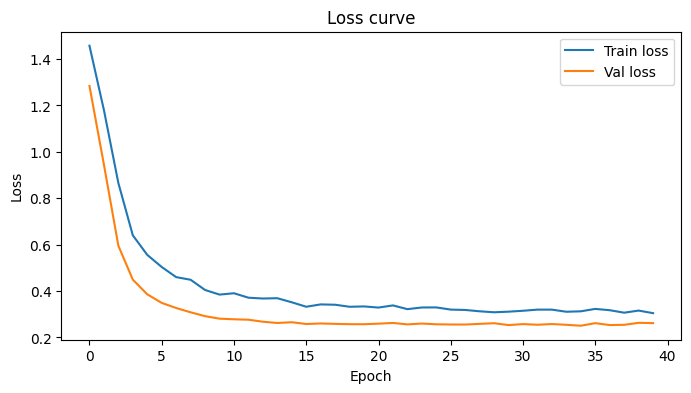

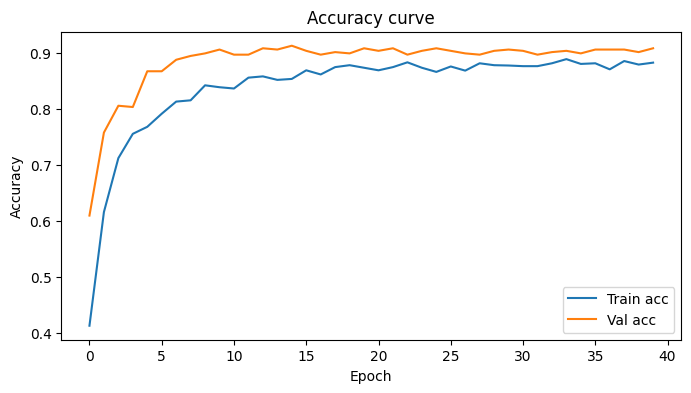

In [14]:
#PLot training curves

import matplotlib.pyplot as plt

history_dict = history.history

plt.figure(figsize=(8,4))
plt.plot(history_dict["loss"], label="Train loss")
plt.plot(history_dict["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss curve")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history_dict["accuracy"], label="Train acc")
plt.plot(history_dict["val_accuracy"], label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy curve")
plt.show()


14/14 [==============================] - 0s 3ms/step
Validation accuracy: 0.8995433789954338


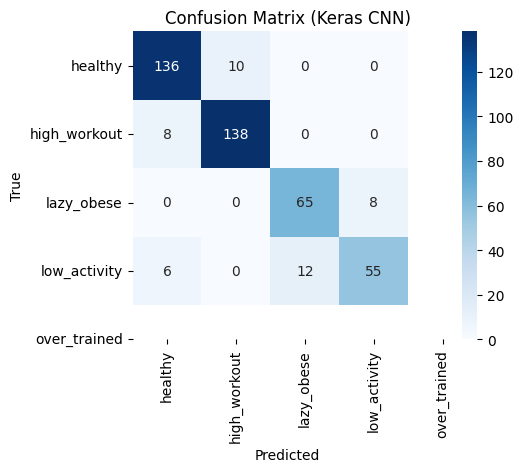

In [15]:
#Accuracy & Confusion Matrix
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Predict class indices for validation set
y_val_probs = model.predict(x_val_cnn)
y_val_pred  = np.argmax(y_val_probs, axis=1)

val_acc = accuracy_score(y_val_cnn, y_val_pred)
print("Validation accuracy:", val_acc)


# Confusion matrix
cm = confusion_matrix(y_val_cnn, y_val_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm, annot=True, fmt="d",
    xticklabels=class_names,
    yticklabels=class_names,
    cmap="Blues"
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Keras CNN)")
plt.show()




In [16]:
#Phase 8: Prediction + Feedback System
#Predict Funtion
def predict_activity_for_row_keras(row, model, scaler, label_encoder, feature_cols):
    # 1) take 3 features
    x = row[feature_cols].to_numpy().astype("float32").reshape(1, -1)
    
    # 2) scale like training
    x_scaled = scaler.transform(x)
    
    # 3) reshape for CNN: (1, 3, 1)
    x_cnn = x_scaled.reshape(1, 3, 1)
    
    # 4) model prediction
    probs = model.predict(x_cnn, verbose=0)[0]   # shape (4,)
    pred_idx = int(np.argmax(probs))
    
    pred_label = label_encoder.inverse_transform([pred_idx])[0]
    return pred_label, probs


In [17]:
def generate_feedback(row, predicted_label, probs):
    steps   = row["steps"]
    stress  = row["average_stress_level"]
    rest_hr = row["resting_heart_rate_in_beats_per_minute"]
    
    confidence = float(np.max(probs)) * 100
    
    summary = (
        f"Today: {steps:.0f} steps, "
        f"stress level {stress:.1f}, "
        f"resting heart rate {rest_hr:.1f} bpm.\n\n"
    )
    
    if predicted_label == "high_workout":
        msg = (
            "You look like a highly active person. "
            "Your step count is high and your heart looks strong. "
            "Keep this routine, and remember to include recovery days."
        )
    elif predicted_label == "healthy":
        msg = (
            "You have a balanced health profile. "
            "Your activity, stress, and heart rate are in a healthy range. "
            "Try to keep this pattern consistent throughout the week."
        )
    elif predicted_label == "low_activity":
        msg = (
            "Your stress and resting heart rate are okay, "
            "but your activity level is a bit low today. "
            "A 10–15 minute walk or light exercise can already make a big difference."
        )
    elif predicted_label == "lazy_obese":
        msg = (
            "Your activity level is quite low and your resting heart rate is on the higher side. "
            "Don't feel pressured to change everything at once. "
            "Start with small goals like adding 1500–2000 steps per day, "
            "and slowly build from there. Small consistent steps bring big results."
        )
    else:  
        msg = (
            "You are very active, but your stress and heart rate suggest that your body "
            "might not be fully recovering. Consider adding an easy day, more sleep, "
            "and light movement instead of intense training. Recovery is also training."
        )
    
    conf_line = f"\n\nModel confidence for '{predicted_label}': {confidence:.1f}%."
    
    return summary + msg + conf_line


In [21]:
#Test
sample_row = data[data["activity_label"] == "over_trained"].sample(1).iloc[0]

pred_label, probs = predict_activity_for_row_keras(
    sample_row, model, scaler, label_encoder, features_cols
)

print("True label     :", sample_row["activity_label"])
print("Predicted label:", pred_label)
print("\n--- FEEDBACK ---\n")
print(generate_feedback(sample_row, pred_label, probs))

row = sample_row
user = row["sdv_user_id"]

sub = data[data["sdv_user_id"] == user]

print("USER:", user)
print("steps:", row["steps"], "threshold:", sub["steps"].quantile(0.75))
print("stress:", row["average_stress_level"], "threshold:", sub["average_stress_level"].quantile(0.75))
print("rest_hr:", row["resting_heart_rate_in_beats_per_minute"], "threshold:", sub["resting_heart_rate_in_beats_per_minute"].quantile(0.75))




c:\INHOLLAND UNIVERSITY\Internship Third Year\Project\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


True label     : over_trained
Predicted label: healthy

--- FEEDBACK ---

Today: 12249 steps, stress level 43.0, resting heart rate 73.0 bpm.

You have a balanced health profile. Your activity, stress, and heart rate are in a healthy range. Try to keep this pattern consistent throughout the week.

Model confidence for 'healthy': 97.9%.
USER: 8103
steps: 12249 threshold: 9890.0
stress: 43 threshold: 35.0
rest_hr: 73 threshold: 68.0
